In [1]:
import torch
import torch.nn.functional as F

from mscgpt.data_handler import DataHandler
from mscgpt.tokenizer import Tokenizer
from mscgpt.gpt import MicroSCGPT, GeneExpressionRegressor

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32
CONTEXT_SIZE = 128
LEARNING_RATE = 1e-4
N_HEADS = 4
N_LAYERS = 8
N_EMBED = 256
N_TRAIN_STEPS = 20000
INTERVAL_EVAL = 100
N_EVAL = 200
DROPOUT = .1
MASK_P = .2

In [3]:
tk = Tokenizer()
dh = DataHandler(BATCH_SIZE, CONTEXT_SIZE, tk.pad_token, device=DEVICE)

tokenized_data = tk.load_pretraining_dataset("tabmuris_A")
tokenized_data = tk.load_pretraining_dataset("humaneye")
dh.load_dataset(tokenized_data)

> Tokenizer: 6395 genes successfully loaded.
> Data Handler: Dataset successfully loaded.


In [4]:
@torch.no_grad()
def estimate_loss(model_gpt, model_gexpr, eval_iters):
  out = {}
  model_gpt.eval()
  model_gexpr.eval()
  for split in ('train', 'val'):
    losses = torch.zeros(eval_iters)
    for k in range(eval_iters):
      x_gid, x_bin = dh.get_batch(split)
      masked_gid, masked_bin, mask = dh.generate_mask(x_gid, x_bin, tk.pad_token, MASK_P)
      x_emb = model_gpt(masked_gid, masked_bin)
      estimate = model_gexpr(x_emb)
      losses[k] = dh.gene_expression_loss(x_gid, x_bin, estimate, mask).item()
    out[split] = losses.mean()
  model_gpt.train()
  model_gexpr.train()
  return out

In [5]:
gpt = MicroSCGPT(CONTEXT_SIZE, tk.bins_size, tk.vocab_size, N_HEADS, N_LAYERS, N_EMBED, N_EMBED, DROPOUT)
gexpr = GeneExpressionRegressor(CONTEXT_SIZE, N_EMBED, tk.n_genes)
gpt = gpt.to(DEVICE)
gexpr = gexpr.to(DEVICE)
optimizer = torch.optim.AdamW(
  list(gpt.parameters()) + list(gexpr.parameters()), 
  lr=LEARNING_RATE
)

> MicroSCGPT: Model initialized with 5201664 parameters.


In [7]:
print(f'> Starting training on {DEVICE}: {torch.cuda.get_device_name(0)}.')

rec_loss = []
for step in range(N_TRAIN_STEPS):
  if step > 0 and not step % (dh.training_set_size // BATCH_SIZE): # LR decay every epoch
    optimizer.param_groups[0]["lr"] *= 0.9
  if not (step % INTERVAL_EVAL) or step == N_TRAIN_STEPS - 1:
    loss = estimate_loss(gpt, gexpr, N_EVAL)
    print(f'Step {step}, loss={(1000*loss["train"]):.3f}e-3 (train), {(1000*loss["val"]):.3f}e-3 (val)')
  x_gid, x_bin = dh.get_batch("train")
  masked_gid, masked_bin, mask = dh.generate_mask(x_gid, x_bin, tk.pad_token, MASK_P)
  x_emb = gpt(masked_gid, masked_bin)
  estimate = gexpr(x_emb)
  loss = dh.gene_expression_loss(x_gid, x_bin, estimate, mask)
  rec_loss.append(float(loss.detach()))
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()

> Starting training on cuda: Radeon RX 7900 XT.
Step 0, loss=10.875e-3 (train), 11.636e-3 (val)
Step 100, loss=10.401e-3 (train), 11.057e-3 (val)
Step 200, loss=9.888e-3 (train), 10.559e-3 (val)
Step 300, loss=9.104e-3 (train), 9.800e-3 (val)
Step 400, loss=8.147e-3 (train), 9.091e-3 (val)
Step 500, loss=7.685e-3 (train), 8.393e-3 (val)
Step 600, loss=6.795e-3 (train), 7.672e-3 (val)
Step 700, loss=5.973e-3 (train), 6.858e-3 (val)
Step 800, loss=5.327e-3 (train), 6.158e-3 (val)
Step 900, loss=4.692e-3 (train), 5.589e-3 (val)
Step 1000, loss=4.214e-3 (train), 5.023e-3 (val)
Step 1100, loss=3.620e-3 (train), 4.694e-3 (val)
Step 1200, loss=3.254e-3 (train), 4.217e-3 (val)
Step 1300, loss=2.812e-3 (train), 3.679e-3 (val)
Step 1400, loss=2.468e-3 (train), 3.314e-3 (val)
Step 1500, loss=2.202e-3 (train), 3.063e-3 (val)
Step 1600, loss=2.040e-3 (train), 2.748e-3 (val)
Step 1700, loss=1.775e-3 (train), 2.574e-3 (val)
Step 1800, loss=1.616e-3 (train), 2.441e-3 (val)
Step 1900, loss=1.468e-3 (tr

Text(0, 0.5, 'log(loss)')

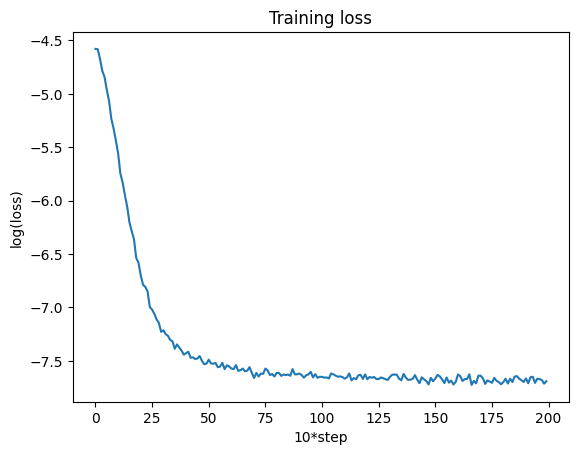

In [9]:
import matplotlib.pyplot as plt

plt.plot(torch.tensor(rec_loss).view(-1, 100).log().mean(axis=-1))
plt.title("Training loss")
plt.xlabel("10*step")
plt.ylabel("log(loss)")

In [10]:
# The loss had been optimized :)